# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# базовые библиотека
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import random
import matplotlib.pyplot as plt
import seaborn as sns

# кодирование и масштабирование
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# цвет текста
from IPython.display import display_html
from IPython.core.display import display, HTML

#Модели обучения
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score

state = np.random.RandomState(12345) # закрепляем весь рандом в проекте

In [2]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [3]:
def data_info(data):
    display(HTML(f'<font color="red"> Общая информация о датасете </font>'))
    display(data.info())
    
    display(HTML(f'<font color="red"> Описание данных </font>'))
    display(data.describe())
    
    display(HTML(f'<font color="red"> Описание категориальных данных </font>'))
    display(data.describe(include=[object]))
    
    display(HTML(f'<font color="red"> Пропущенные значения признаков </font>'))
    nan_values_data = data.isna().sum().sort_values(ascending=False)
    display(nan_values_data.loc[nan_values_data > 0])
    
    display(HTML(f'<font color="red"> Heatmap пропущенных значений </font>'))
    plt.figure(figsize=(20, 20))
    sns.heatmap(data.isnull(), cmap=sns.color_palette('viridis', as_cmap=True))
    plt.show()
    
    
    display(HTML('<font color="red"> Если удалить все строки с пропущенными значениями получим <font color="blue">{:.0%}</font> потерянных данных </font>'
             .format(1 - (data.dropna(axis=0).shape[0] / data.shape[0]))))
    
    if (100 - (data.dropna(axis=0).shape[0] / data.shape[0]) * 100) > 10:
        display(HTML(f'<font color="red"> Данные <font color="blue">НУЖДАЮТСЯ</font> в предобработке </font>'))
        
    else:
        display(HTML(f'<font color="red"> Данные <font color="blue">НЕ НУЖДАЮТСЯ</font> в предобработке </font>'))
        
    
    # Correlation Heatmap числовых признаков
    numeric_columns = data.select_dtypes(exclude='object').copy(deep=True)
    plt.figure(figsize=(10, 10), dpi=80)
    heatmap = sns.heatmap(numeric_columns.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG',
                      fmt='.2g')
    heatmap.set_title('Correlation Heatmap числовых признаков',fontdict={'fontsize':20}, pad=12)
    plt.show()
    
    #Таблица уникальных значений
    display(HTML(f'<font color="red"> Количество уникальных значений </font>'))
    uniq_dict = {}
    for column in data.columns:
    
        uniq_dict[column] = len(data[column].unique())
    
    display(pd.DataFrame(data=uniq_dict, index=['Unique count']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

DateCrawled VehicleType Gearbox   Model FuelType       Brand  \
count                354369      316879  334536  334664   321474      354369   
unique               271174           8       2     250        7          40   
top     2016-03-24 14:49:47       sedan  manual    golf   petrol  volkswagen   
freq                      7       91457  268251   29232   216352       77013   

       NotRepaired          DateCreated             LastSeen  
count       283215               354369               354369  
unique           2                  109               179150  
top             no  2016-04-03 00:00:00  2016-04-06 13:45:54  
freq        247161                13719                   17

NotRepaired    71154
VehicleType    37490
FuelType       32895
Gearbox        19833
Model          19705
dtype: int64

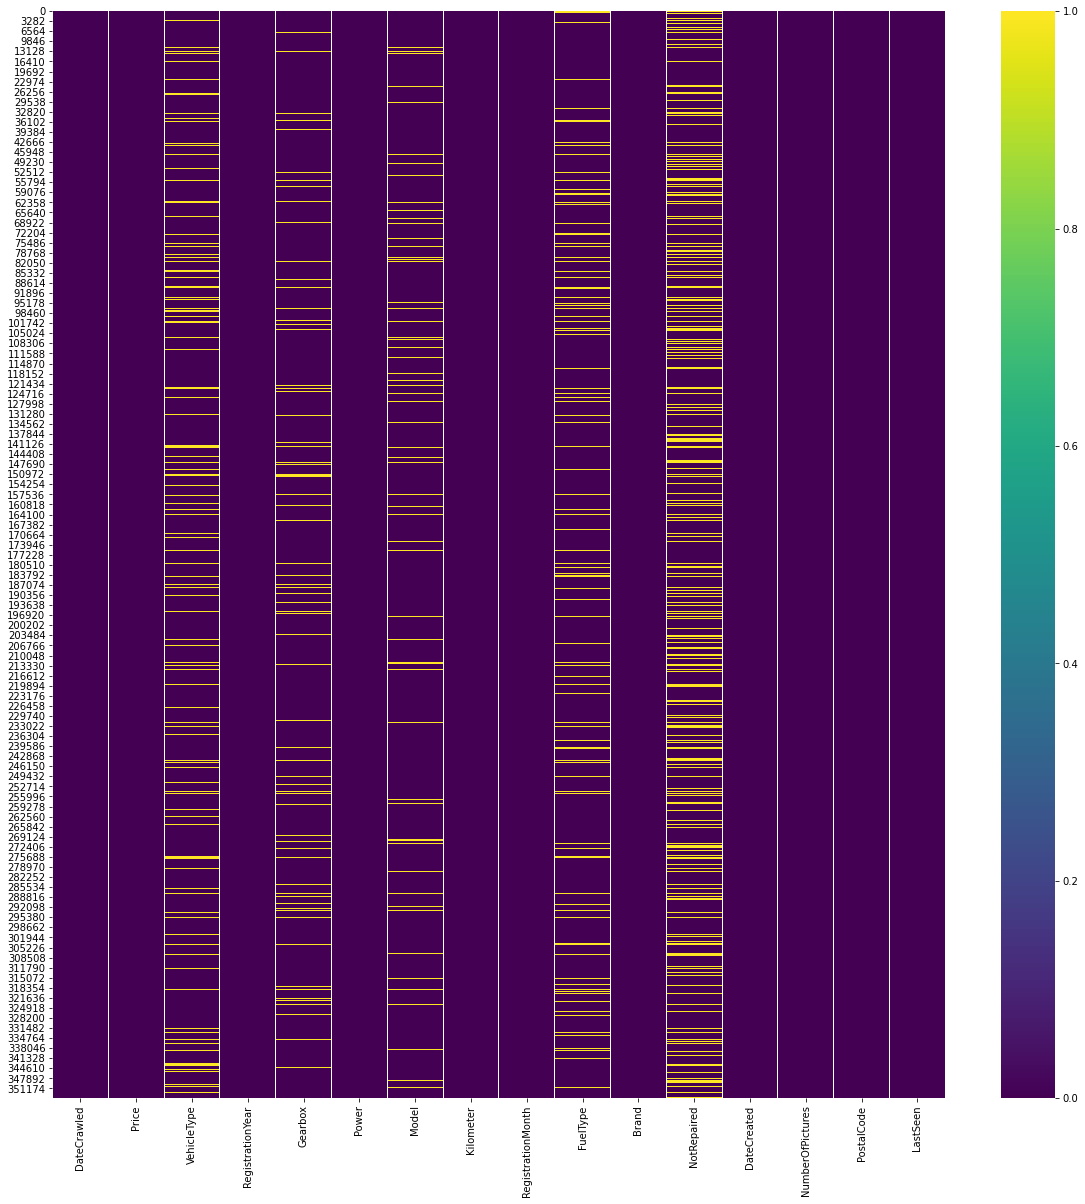

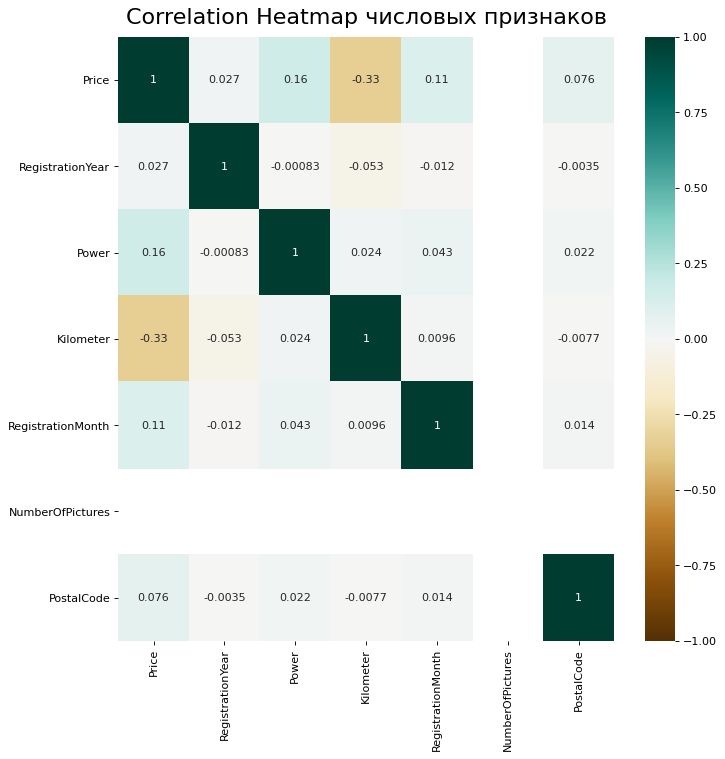

DateCrawled  Price  VehicleType  RegistrationYear  Gearbox  \
Unique count       271174   3731            9               151        3   

              Power  Model  Kilometer  RegistrationMonth  FuelType  Brand  \
Unique count    712    251         13                 13         8     40   

              NotRepaired  DateCreated  NumberOfPictures  PostalCode  LastSeen  
Unique count            3          109                 1        8143    179150

In [9]:
data_info(data)

### Вывод

1) Большое количество пропусков в колонках `NotRepaired`,`VehicleType`,`FuelType`,`Gearbox`,`Model`.

2) В колонке `Price` которая является целевой есть нулевые значения - необходимо их убрать для корректности обучения.

3) Удалить неинформативные колонки `DateCrawled` `RegistrationMonth` `DateCreated` `NumberOfPictures` `PostalCode` `LastSeen` которые можно удалить.

4) В колонках `Price` и `RegistrationYear` присутствуют неадекватные значения, как например 0 для цены и 9999 для года регистрации.

5) Удалить потенциальные дубликаты

## Предподготовка данных

Присвоим колонкам `NotRepaired`,`VehicleType`,`FuelType`,`Gearbox`,`Model` заглушку `other` и `unknown`, т.к. установить эти данные иначе мы не можем. (На самом деле потенциально можем, соотнеся тип кузова и модель авто, но пока остановимся на этом).

In [10]:
# количество строк ДО предобработки
before_preprocessing = data.shape[0]
print(before_preprocessing)

354369


In [11]:
def value_analysis(row, min, max, step, table_title):
    
    # количество выбросов после определенного значения
    total_min = (row <= min).sum() 
    total_max = (row >= max).sum()
    
    # графики
    # гистограмма 
    fig = plt.figure(figsize=(15, 6))
    ax1 = plt.subplot(1, 2, 1) # (дллина оси по X, дллина оси по Y, занимаемая позиция графика на оси)
    ax1 = row.plot(kind='hist', bins=((max-min)//2), range=(min,max), title=table_title)
    ax1.set_xlabel('Годы')
    ax1.set_ylabel('Количество')
    major_ticks_ax1 = range(min, max, step)
    ax1.set_xticks(major_ticks_ax1)
    ax1.grid(True,which='major', alpha=0.5)
    
    
    # ящик с усами
    ax2 = plt.subplot(1, 2, 2) # (дллина оси по X, дллина оси по Y, занимаемая позиция графика на оси)
    ax2 = row.plot(kind='box', title=table_title)
    plt.ylim(min, max)
    major_ticks_ax2 = range(min, max, step)
    ax2.set_yticks(major_ticks_ax2)
    ax2.grid(True,which='major', alpha=0.5)
    plt.show()
    
    # таблица
    index_list = [f'Выбросы < {min}', f'Выбросы > {max}', 'Σ выбросы']
    percent_list = [(total_min*100)/len(row), (total_max*100)/len(row), ((total_min + total_max)*100)/len(row)]
    df = pd.DataFrame(np.array(percent_list), index=[index_list], columns=[table_title])
    display(df.round(2))  

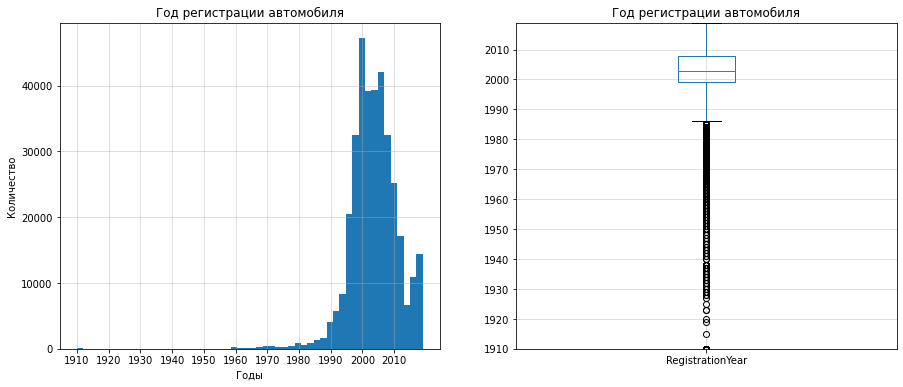

Год регистрации автомобиля
Выбросы < 1910                        0.05
Выбросы > 2019                        0.04
Σ выбросы                             0.08

In [12]:
value_analysis(data['RegistrationYear'], 1910, 2019, 10, 'Год регистрации автомобиля')

**Очень маленькое количество выбросов. Можем удалить эти строчки**

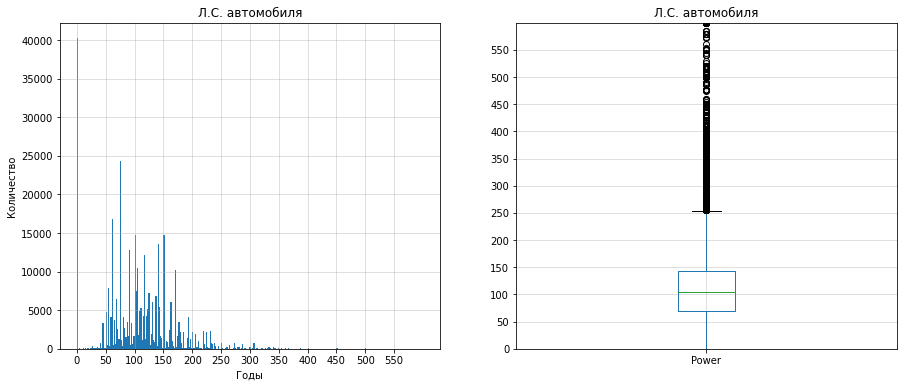

Л.С. автомобиля
Выбросы < 0              11.35
Выбросы > 600             0.11
Σ выбросы                11.46

In [13]:
value_analysis(data['Power'], 0, 600, 50, 'Л.С. автомобиля')

**Исследование показало что максимальная мощность машины на момент 2019 года достигала приблизительно 2000 л.с. Это значение и будем считать максимальным, в свою очередь как минимальное значение было у первого автомобиля Ford T с показателем 11 л.с.**

**Суммарное значение выбросов 11.54% это очень много. Заменим нулевые значение медианой**

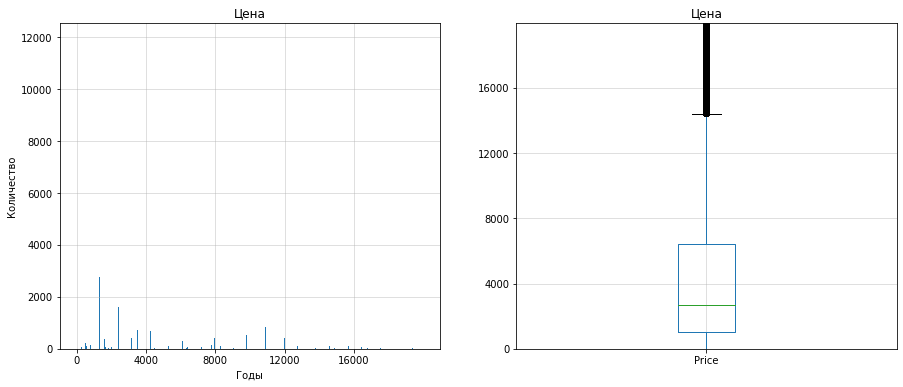

Цена
Выбросы < 0      3.04
Выбросы > 20000  0.08
Σ выбросы        3.12

In [14]:
value_analysis(data['Price'], 0, 20000, 4000, 'Цена')

**Есть много нулевых значений - 3.03% Удалим их**

In [15]:
len(data.loc[data['Power'] == 0, 'Power'])

40225

In [16]:
# заменим 0 значения мощности на медиану относительно модели
data.loc[data['Power'] == 0, 'Power'] = np.nan
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))

In [17]:
len(data.loc[data['Power'] == np.nan, 'Power'])

0

In [18]:
# избавляемся от выбросов
data = data.query("1910 <= RegistrationYear <= 2019 & Power <= 600")
data = data.query("Power >= 11").reset_index(drop=True)

In [19]:
# переведём значение в DateCrawled
data['DateCrawled_year'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S').dt.year

In [20]:
data['DateCrawled_year'].unique()

array([2016])

<Figure size 1080x432 with 0 Axes>

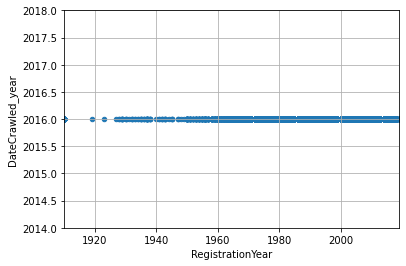

In [21]:
fig = plt.figure(figsize=(15, 6))
ax1 = data[['DateCrawled_year', 'RegistrationYear']].plot(kind='scatter', y='DateCrawled_year', x='RegistrationYear', grid=True)

plt.ylim((data['DateCrawled_year'].min()-2), (data['DateCrawled_year'].max() + 2))
plt.xlim((data['RegistrationYear'].min()), (data['RegistrationYear'].max()))
plt.show()

In [22]:
# удалим неинформативные колонки
drop_list = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCrawled_year']
data = data.drop(labels=drop_list, axis=1)

In [23]:
# заменим пропуски
nan_other = [ 'VehicleType', 'FuelType', 'Model'] # колонки с пропусками
nan_unknow = ['NotRepaired', 'Gearbox']
data[nan_other] = data[nan_other].fillna('other') # заменяем пропуски на other 
data[nan_unknow] = data[nan_unknow].fillna('unknow') # заменяем пропуски на other 

In [24]:
# уберём значение цены равняющееся 0
data_shape_total = data.shape[0]
data_price_before = len(data.query('Price != 0'))
data = data.drop(index=data.query('Price == 0').index).reset_index(drop=True)


display(HTML('<font color="red"> Процент удалённых строчек с ценой равной 0 : <font color="blue">{:.2%}</font> </font>'.format((1 - (data_price_before) / data_shape_total))))

In [25]:
# Удалим Дубликаты
print(f'Данные ДО удаления дубликатов: {data.shape[0]}')
data = data.drop_duplicates(keep='first', ignore_index=False).reset_index(drop=True)
print(f'Данные ПОСЛЕ удаления дубликатов: {data.shape[0]}')

Данные ДО удаления дубликатов: 337896
Данные ПОСЛЕ удаления дубликатов: 293786


In [26]:
293786*100/337896 - 100

-13.054312569548031

In [27]:
# количество строк ПОСЛЕ предобработки
after_preprocessing = data.shape[0]
print(after_preprocessing)

293786


In [28]:
display(HTML('<font color="red"> После предобработки итоговые потери составили <font color="blue">{:.2%}</font> потерянных данных </font>'.format((1 - (after_preprocessing) / before_preprocessing))))

### Вывод

Были проведены работы по очистке данных - итоговые потери составили 3.25% от всей выборки.

1) Заменены данные пропущенные значения в колонках `NotRepaired`,`VehicleType`,`FuelType`,`Gearbox`,`Model`.

2) Убрали 0 из колонки `Price`.

3) Удалить неинформативные колонки `DateCrawled` `RegistrationMonth` `DateCreated` `NumberOfPictures` `PostalCode` `LastSeen`.

4) Обработали выбросы в колонках `Power`, `RegistrationYear`, `Price`.

5) Удалены дубликаты

**Итог:** Потери составили 17.10% от всей выборки.

## Кодирование данных

Опираясь на эту картинку https://www.machinelearningmastery.ru/img/0-169452-929424.png я пришел к выводу что для деревянных моделей мы будем использовать Target Encoder, а для для бустинга OHE, но т.к. у нас много категорий то следует применить Ordinal Encoding.

### Применим метод Target encoder 

In [29]:
# исправленная
def target_enc(data):
    '''
    Input: --> pd.Dataframe
    Output --> pd.Dataframe, pd.Dataframe, pd.Dataframe, pd.Series, pd.Series
    Process: 1. Создаём копию основного датасета
             2. Выделим числовые и категориальные признаки
             3. Применяем кодирование ко всем категориальныем признакам
             4. Выделим X и y
             5. Разделим датасет на тренировочный и тестовые выборки
             6. Масштабируем числовые признаки
    '''
    # скопируем уникальный датасет
    data_TE = data.copy()
    
    # Выделим X и y
    X = data_TE.loc[:].drop(columns=['Price']).copy()
    y = data_TE.loc[: ,'Price'].copy()
    
    # Разделим датасет
    X_train, X_test, y_train, y_test = train_test_split(X.loc[:], y.loc[:], test_size=0.4, random_state=12345)
    
    # выделим числовые и категориальные признаки
    numeric_X = list(data_TE.select_dtypes(exclude='object').columns)
    numeric_X.remove('Price')
    categorial_X = list(data_TE.select_dtypes(include='object').columns)
        
           
    # применяем кодирование ко всем колонкам
    encoder = TargetEncoder()
    encoder.fit(X_train.loc[:, categorial_X], y_train)
    X_train.loc[:, categorial_X] = encoder.transform(X_train.loc[:, categorial_X])
    X_test.loc[:, categorial_X] = encoder.transform(X_test.loc[:, categorial_X])

    
    # Масштабируем числовые признаки
    scaler = StandardScaler()
    scaler.fit(X_train.loc[:, numeric_X])
    X_train.loc[:, numeric_X] = scaler.transform(X_train[numeric_X])
    X_test.loc[:, numeric_X] = scaler.transform(X_test[numeric_X])
    
    return X_train, X_test, y_train, y_test

In [30]:
X_train_TE, X_test_TE, y_train_TE, y_test_TE = target_enc(data)

/opt/conda/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/opt/conda/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


### Применим метод Ordinal encoder 

In [31]:
def ordinal_enc(data):
    '''
    Input: --> pd.Dataframe
    Output --> pd.Dataframe, pd.Dataframe, pd.Dataframe, pd.Series, pd.Series
    Process: 1. Создаём копию основного датасета
             2. Выделим числовые и категориальные признаки
             3. Применяем кодирование ко всем категориальныем признакам
             4. Соединим все данные в новом датафрейме
             4. Выделим X и y
             5. Разделим датасет на тренировочный и тестовые выборки
             6. Масштабируем числовые признаки
    '''
    # скопируем уникальный датасет
    data_OE = data.copy()
    
    # Выделим X и y
    X = data_OE.loc[:].drop(columns=['Price']).copy()
    y = data_OE.loc[: ,'Price'].copy()
    
    # Разделим датасет
    X_train, X_test, y_train, y_test = train_test_split(X.loc[:], y.loc[:], test_size=0.4, random_state=12345)
    
    # выделим числовые и категориальные признаки
    numeric_X = list(data_OE.select_dtypes(exclude='object').columns)
    numeric_X.remove('Price')
    categorial_X = list(data_OE.select_dtypes(include='object').columns)
    
    # Применение OrdinalEncoder
    encoder = OrdinalEncoder()
    encoder.fit(X_train.loc[:, categorial_X])
    X_train.loc[:, categorial_X] = encoder.transform(X_train.loc[:, categorial_X])
    X_test.loc[:, categorial_X] = encoder.transform(X_test.loc[:, categorial_X])
    
    # Масштабируем числовые признаки
    scaler = StandardScaler()
    scaler.fit(X_train.loc[:, numeric_X])
    X_train.loc[:, numeric_X] = scaler.transform(X_train.loc[:, numeric_X])
    X_test.loc[:, numeric_X] = scaler.transform(X_test.loc[:, numeric_X])
    
    return X_train, X_test, y_train, y_test

In [32]:
X_train_OE, X_test_OE, y_train_OE, y_test_OE = ordinal_enc(data)

## Обучение моделей

### Подбор гиперпараметров

In [33]:
def grid_params(model, params, scoring, features, target):
    '''    
    Input: --> learning algoritm, model parametrs --> dict, scoring method --> str, pd.DataFrame, pd.Series
    Output --> learning algoritm, model_grid.best_params_ --> dict, model_grid.best_score_
    Process: 1. Задаём параметры GridSearchCV
             2. Обучаем модель
             3. Сохраняем лучшие параметры и лучший показатель метрики
    '''        
    
    model_grid = GridSearchCV(model, params,
                              n_jobs=-1, cv=5, scoring=scoring)
    model_grid.fit(features, target)
    best_params = model_grid.best_params_
    best_score = model_grid.best_score_
    
    display(model_grid)
    display(best_params)
    display(HTML(f'<font color="red"> Лучший результат RMSE:{best_score}</font>'))
    return model_grid, best_params, best_score

#### Дерево решений

In [34]:
tree_model = DecisionTreeRegressor(random_state=12345)
tree_params = {'max_depth': range(3, 8, 1)}

In [35]:
# Обучение с Target Encoding
start = timer()
model_best_tree_TE, best_params_tree_TE , best_score_tree_TE = grid_params(tree_model, tree_params, 'neg_root_mean_squared_error', X_train_TE, y_train_TE)
end = timer()

tree_timetrain_TE = round((end - start), 2)
print(tree_timetrain_TE)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1, param_grid={'max_depth': range(3, 8)},
             scoring='neg_root_mean_squared_error')

{'max_depth': 7}

3.82


In [36]:
# Обучение с Ordinal Encoding

start = timer()
model_best_tree_OE, best_params_tree_OE , best_score_tree_OE = grid_params(tree_model, tree_params, 'neg_root_mean_squared_error', X_train_OE, y_train_OE)
end = timer()

tree_timetrain_OE = round((end - start), 2)
print(tree_timetrain_OE)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1, param_grid={'max_depth': range(3, 8)},
             scoring='neg_root_mean_squared_error')

{'max_depth': 7}

4.06


#### Случайный лес

In [37]:
forest_model = RandomForestRegressor(random_state=12345)
forest_params = {'max_depth': range(1,5,1),
                'n_estimators': range(100,150,10)}


In [38]:
# Обучение с Ordinal Encoding

start = timer()
model_best_forest_OE, best_params_forest_OE , best_score_forest_OE = grid_params(forest_model, forest_params, 'neg_root_mean_squared_error', X_train_OE, y_train_OE)
end = timer()

forest_timetrain_OE = round((end - start), 2)
print(forest_timetrain_OE)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 5),
                         'n_estimators': range(100, 150, 10)},
             scoring='neg_root_mean_squared_error')

{'max_depth': 4, 'n_estimators': 100}

642.91


In [39]:
# Обучение с Target Encoding
start = timer()
model_best_forest_TE, best_params_forest_TE , best_score_forest_TE = grid_params(forest_model, forest_params, 'neg_root_mean_squared_error', X_train_TE, y_train_TE)
end = timer()

forest_timetrain_TE = round((end - start), 2)
print(forest_timetrain_TE)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 5),
                         'n_estimators': range(100, 150, 10)},
             scoring='neg_root_mean_squared_error')

{'max_depth': 4, 'n_estimators': 110}

640.95


#### Линейная регрессия

In [40]:
# Обучение с Ordinal Encoding
start = timer()
cv_sc_linReg_OE = cross_val_score(LinearRegression(),
                                        X_train_OE,
                                        y_train_OE,
                                        cv=5, scoring='neg_root_mean_squared_error').mean()
end = timer()
linreg_timetrain_OE = round((end - start), 2)
display(HTML(f'<font color="red"> Лучший результат RMSE:{cv_sc_linReg_OE}</font>'))

In [41]:
# Обучение с Target Encoding
start = timer()
cv_sc_linReg_TE = cross_val_score(LinearRegression(),
                                        X_train_TE,
                                        y_train_TE,
                                        cv=5, scoring='neg_root_mean_squared_error').mean()
end = timer()
linreg_timetrain_TE = round((end - start), 2)
display(HTML(f'<font color="red"> Лучший результат RMSE:{cv_sc_linReg_TE}</font>'))

#### CatBoost

In [42]:
# выбираем все категориальные признаки
cat_features = data.select_dtypes(include='object').columns.tolist()
cat_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [43]:
cat_model = CatBoostRegressor()
cat_params = {'depth': [4], 
              'loss_function': ["RMSE"], 
              'iterations': range(550, 750, 50),
              'learning_rate': np.arange(0.021,0.025,0.001),
               'verbose': [1],
               'random_state': [12345]}

In [44]:
# метод Orsinl Encoding

start = timer()
model_best_cat_OE, best_params_cat_OE , best_score_cat_OE = grid_params(cat_model, cat_params, 'neg_root_mean_squared_error', X_train_OE, y_train_OE)
end = timer()

cat_timetrain_OE = round((end - start), 2)
print(cat_timetrain_OE)

0:	learn: 4529.6664543	total: 73.9ms	remaining: 40.6s
1:	learn: 4476.1023767	total: 89.7ms	remaining: 24.6s
2:	learn: 4423.2093088	total: 105ms	remaining: 19.2s
3:	learn: 4373.0794504	total: 121ms	remaining: 16.5s
4:	learn: 4323.0890650	total: 146ms	remaining: 15.9s
5:	learn: 4275.8475091	total: 162ms	remaining: 14.7s
6:	learn: 4228.0722565	total: 184ms	remaining: 14.3s
7:	learn: 4181.6399805	total: 200ms	remaining: 13.5s
8:	learn: 4137.9317945	total: 215ms	remaining: 12.9s
9:	learn: 4095.8158937	total: 237ms	remaining: 12.8s
10:	learn: 4054.3002985	total: 258ms	remaining: 12.6s
11:	learn: 4014.1901120	total: 275ms	remaining: 12.3s
12:	learn: 3973.9318243	total: 290ms	remaining: 12s
13:	learn: 3934.6682754	total: 305ms	remaining: 11.7s
14:	learn: 3897.8702449	total: 322ms	remaining: 11.5s
15:	learn: 3860.4853328	total: 338ms	remaining: 11.3s
16:	learn: 3825.5264903	total: 353ms	remaining: 11.1s
17:	learn: 3789.4024954	total: 368ms	remaining: 10.9s
18:	learn: 3754.1612686	total: 383ms	r

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd156714dc0>,
             n_jobs=-1,
             param_grid={'depth': [4], 'iterations': range(550, 750, 50),
                         'learning_rate': array([0.021, 0.022, 0.023, 0.024]),
                         'loss_function': ['RMSE'], 'random_state': [12345],
                         'verbose': [1]},
             scoring='neg_root_mean_squared_error')

{'depth': 4,
 'iterations': 700,
 'learning_rate': 0.024000000000000004,
 'loss_function': 'RMSE',
 'random_state': 12345,
 'verbose': 1}

923.02


In [45]:
# метод Target Encoding

start = timer()
model_best_cat_TE, best_params_cat_TE , best_score_cat_TE = grid_params(cat_model, cat_params, 'neg_root_mean_squared_error', X_train_TE, y_train_TE)
end = timer()

cat_timetrain_TE = round((end - start), 2)
print(cat_timetrain_TE)

0:	learn: 4529.5915882	total: 17.5ms	remaining: 9.63s
1:	learn: 4476.5452193	total: 32.4ms	remaining: 8.88s
2:	learn: 4423.1855655	total: 46.5ms	remaining: 8.47s
3:	learn: 4373.1231113	total: 61.1ms	remaining: 8.34s
4:	learn: 4323.4076462	total: 75.9ms	remaining: 8.28s
5:	learn: 4274.1403480	total: 91.3ms	remaining: 8.28s
6:	learn: 4225.9888379	total: 106ms	remaining: 8.24s
7:	learn: 4179.2437963	total: 120ms	remaining: 8.16s
8:	learn: 4135.0014252	total: 135ms	remaining: 8.11s
9:	learn: 4091.8563344	total: 149ms	remaining: 8.04s
10:	learn: 4049.5363619	total: 165ms	remaining: 8.07s
11:	learn: 4006.8658800	total: 180ms	remaining: 8.06s
12:	learn: 3965.1757534	total: 194ms	remaining: 8.03s
13:	learn: 3924.4402234	total: 209ms	remaining: 8s
14:	learn: 3886.5594932	total: 224ms	remaining: 8.01s
15:	learn: 3848.6438571	total: 239ms	remaining: 7.99s
16:	learn: 3811.9581018	total: 254ms	remaining: 7.97s
17:	learn: 3776.0358538	total: 269ms	remaining: 7.96s
18:	learn: 3741.0186067	total: 284m

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd156714dc0>,
             n_jobs=-1,
             param_grid={'depth': [4], 'iterations': range(550, 750, 50),
                         'learning_rate': array([0.021, 0.022, 0.023, 0.024]),
                         'loss_function': ['RMSE'], 'random_state': [12345],
                         'verbose': [1]},
             scoring='neg_root_mean_squared_error')

{'depth': 4,
 'iterations': 700,
 'learning_rate': 0.024000000000000004,
 'loss_function': 'RMSE',
 'random_state': 12345,
 'verbose': 1}

824.11


#### LightGBM

In [46]:
lgbm_model = LGBMRegressor()
lgbm_params = {'max_depth': range(1,5,1),
                   'objective': ['regression'],
                   "metric": ['rmse'],
                   'n_estimators': range(550, 750, 50),
                   'learning_rate':np.arange(0.021,0.024,0.001),
                    "verbosity": [1],
                   'random_state': [12345],
                   "boosting_type": ['gbdt']}


**Т.к. catboost показал лучший результат именно с Target Encoding будем применять его для обучения LightGBM**

In [47]:
# Обучение с Ordinal Encoding
start = timer()
model_best_lgbm_OE, best_params_lgbm_OE , best_score_lgbm_OE = grid_params(lgbm_model , lgbm_params, 'neg_root_mean_squared_error', X_train_OE, y_train_OE)
end = timer()

lgbm_timetrain_OE = round((end - start), 2)
print(lgbm_timetrain_OE)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 141016, number of used features: 9
[LightGBM] [Info] Start training from score 4683.822375
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 141017, number of used features: 9
[LightGBM] [Info] Start training from score 4684.050682
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': array([0.021, 0.022, 0.023]),
                         'max_depth': range(1, 5), 'metric': ['rmse'],
                         'n_estimators': range(550, 750, 50),
                         'objective': ['regression'], 'random_state': [12345],
                         'verbosity': [1]},
             scoring='neg_root_mean_squared_error')

{'boosting_type': 'gbdt',
 'learning_rate': 0.023000000000000003,
 'max_depth': 4,
 'metric': 'rmse',
 'n_estimators': 700,
 'objective': 'regression',
 'random_state': 12345,
 'verbosity': 1}

5334.51


In [48]:
# Обучение с Target Encoding
start = timer()
model_best_lgbm_TE, best_params_lgbm_TE , best_score_lgbm_TE = grid_params(lgbm_model , lgbm_params, 'neg_root_mean_squared_error', X_train_TE, y_train_TE)
end = timer()

lgbm_timetrain_TE = round((end - start), 2)
print(lgbm_timetrain_TE)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.204026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 141016, number of used features: 9
[LightGBM] [Info] Start training from score 4683.822375
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 141017, number of used features: 9
[LightGBM] [Info] Start training from score 4684.050682
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': array([0.021, 0.022, 0.023]),
                         'max_depth': range(1, 5), 'metric': ['rmse'],
                         'n_estimators': range(550, 750, 50),
                         'objective': ['regression'], 'random_state': [12345],
                         'verbosity': [1]},
             scoring='neg_root_mean_squared_error')

{'boosting_type': 'gbdt',
 'learning_rate': 0.023000000000000003,
 'max_depth': 4,
 'metric': 'rmse',
 'n_estimators': 700,
 'objective': 'regression',
 'random_state': 12345,
 'verbosity': 1}

3572.42


### Вывод

Подбор параметров осуществлён с помощью метода GridresearchCV

Были обучены модели методами: Дерево решений, Случайный лес, Линейная регрессия и модели обучения градиентного бустинга: CatBoost и LightGBM.

## Анализ моделей

In [49]:
result_dict = {'Model': [], 'RMSE': [], 'Time_spend_predict(sec)': []}

def test_model(model, X_test, y_test, label_model):
    start = timer()
    predict = model.predict(X_test)
    end = timer()
    
    RMSE = mean_squared_error(predict , y_test)**0.5
    timetest = round((end - start), 2)
    
    
    result_dict['Model'].append(label_model)
    result_dict['RMSE'].append(RMSE)
    result_dict['Time_spend_predict(sec)'].append(timetest)
    
    print(f'Время на предсказание {label_model} : {timetest}')
    print(f'Точность предсказания {label_model}: {RMSE}')

In [50]:
# тест для Ordinal Encoder
model_list = [model_best_tree_OE, model_best_forest_OE, model_best_cat_OE, model_best_lgbm_OE]
lable_list = ['Дерево решений OE', 'Случайный лес OE', 'CatBoost OE', 'LightGBM OE']
for model, lable in zip(model_list, lable_list):
    test_model(model, X_test_OE, y_test_OE, lable)

Время на предсказание Дерево решений OE : 0.01
Точность предсказания Дерево решений OE: 2262.3030435952764
Время на предсказание Случайный лес OE : 0.34
Точность предсказания Случайный лес OE: 2672.507485692924
Время на предсказание CatBoost OE : 0.07
Точность предсказания CatBoost OE: 1898.9862447378546
Время на предсказание LightGBM OE : 5.46
Точность предсказания LightGBM OE: 1823.3791424517585


In [51]:
# тест для Target Encoder
model_list = [model_best_tree_TE, model_best_forest_TE, model_best_cat_TE, model_best_lgbm_TE]
lable_list = ['Дерево решений TE', 'Случайный лес TE', 'CatBoost TE', 'LightGBM TE']
for model, lable in zip(model_list, lable_list):
    test_model(model, X_test_TE, y_test_TE, lable)

Время на предсказание Дерево решений TE : 0.01
Точность предсказания Дерево решений TE: 2222.4620400755666
Время на предсказание Случайный лес TE : 0.35
Точность предсказания Случайный лес TE: 2620.6581054518538
Время на предсказание CatBoost TE : 0.07
Точность предсказания CatBoost TE: 1844.5867538934895
Время на предсказание LightGBM TE : 4.96
Точность предсказания LightGBM TE: 1785.5644932982677


In [52]:
# сводная таблица результатов ОБУЧЕНИЯ МОДЕЛЕЙ
results_rmse = {'Model': ['Дерево решений OE', 'Дерево решений TE', 'Случайный лес OE', 'Случайный лес TE', 'Линейная регрессия OE', 'Линейная регрессия TE', 'CatBoost OE', 'CatBoost TE', 'LightGBM TE', 'LightGBM OE'], 
                'RMSE': [best_score_tree_OE, best_score_tree_TE, best_score_forest_OE, best_score_forest_TE, cv_sc_linReg_OE, cv_sc_linReg_TE, best_score_cat_OE, best_score_cat_TE, best_score_lgbm_TE, best_score_lgbm_OE], 
                'Time_spend(sec)': [tree_timetrain_OE, tree_timetrain_TE, forest_timetrain_OE, forest_timetrain_TE, linreg_timetrain_OE, linreg_timetrain_TE, cat_timetrain_OE, cat_timetrain_TE, lgbm_timetrain_TE, lgbm_timetrain_OE]}

In [53]:
result_data = (pd.DataFrame(results_rmse).sort_values(by=['RMSE']).sort_values(by='RMSE', ascending=False)
                  .style.background_gradient(subset=['RMSE'], cmap=sns.color_palette("vlag_r", as_cmap=True))
              .background_gradient(subset=['Time_spend(sec)'], cmap=sns.color_palette("vlag", as_cmap=True)))
result_data

In [54]:
# сводная таблица результатов ТЕСТИРОВАНИЯ МОДЕЛЕЙ
result__test_data = (pd.DataFrame(result_dict).sort_values(by=['RMSE']).sort_values(by='RMSE', ascending=False)
                  .style.background_gradient(subset=['RMSE'], cmap=sns.color_palette("vlag", as_cmap=True))
              .background_gradient(subset=['Time_spend_predict(sec)'], cmap=sns.color_palette("vlag", as_cmap=True)))
result__test_data

Проверка на тестовой выборке осуществлялась с кодированием методом `Ordinal Encoding`. Проверка на тестовой выборке осуществлялась с кодированием методом `Ordinal Encoding`. Лучший результат продемонстрировала модель `LightGBM`, но при этом она имеет очень низкую скорость предсказания по сравнению с ближайшим конкурентом `CatBoost`, который незначительно проигрывает в точности.

## Вывод

1. Был проведён EDA и выявлены основные проблемы с данными.
2. Испрвлены пропуски в данных, удалены не информативные колонки, удалены выбросы и неявные дубликаты
3. Данные закодированы методами Target Encoding и Ordinal Encoding
4. Обучены 5 мделей обучения на каждый метод кодирования. Результаты занесены в таблицу.
5. Протестированы все модели обучения на соответствующих тестовых выборках. Результаты занесены в таблицу.

**Итоги**: Лучший результат  на тестовой выборке продемонстрировала модель `LightGBM OE`, но при этом она имеет очень низкую скорость предсказания по сравнению с ближайшим конкурентом по точности `CatBoost TE`.

